rmsprop

In [1]:
from glob import glob
import os, sys, scipy
from scipy.stats import chi2, poisson
import numpy as np

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16})

from prettytable import PrettyTable

In [2]:
import ROOT as rt
import root_numpy as rtnp
from utility_func import *

Welcome to JupyROOT 6.10/08


/Users/olmo/programs/root-6.10.08/lib/ROOT.py:318: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return _orig_ihook( name, *args, **kwds )
Using TensorFlow backend.


In [3]:
from keras.layers import Input, Dense, Lambda, Layer
from keras.models import Model
from keras import backend as K
from keras import layers as KL
from keras import metrics
from keras import optimizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN, ModelCheckpoint
from keras.constraints import max_norm
import keras
print keras.__version__

2.1.2


In [4]:
do_training = 0

# Get the samples

In [5]:
hlf_features = ['HT', 'METp', 'METo', 'MT', 'nJets', 
                'bJets', 'allJetMass', 'LepPt', 'LepEta', 
                'LepIsoCh', 'LepIsoGamma', 'LepIsoNeu', 'LepCharge', 
                'LepIsEle', 'nMu', 'allMuMass', 'allMuPt', 'nEle', 
                'allEleMass', 'allElePt', 'nChHad', 'nNeuHad', 'nPhoton']

active_hlf_features = ['HT', 'allJetMass',
                       'allMuPt', 'allMuMass',
                       'allElePt','allEleMass',
                       'LepPt', 'LepIsoCh', 'LepIsoGamma', 'LepIsoNeu',
                       
                       'METp', 'METo',
                       
                       'MT',
                       
                       'nMu', 'nJets', 'bJets', 'nEle', 
                       
                       'LepCharge','LepIsEle', 
                       
                       'nChHad', 'nNeuHad']

Nf_lognorm = 10
Nf_gauss = 2
Nf_Pgauss = 1
Nf_PDgauss = 4
Nf_binomial = 2
Nf_poisson = 2

sel = []
for a in active_hlf_features:
    for i,f in enumerate(hlf_features):
        if a == f:
            sel.append(i)
# print 'Activated HLF:'
# for n in np.array(hlf_features)[sel]:
#     print '\t', n

In [6]:
data_folder = '../../data/HLF_ONLY/'
TrainSamplesName = ['Wlnu', 'qcd', 'Zll', 'ttbar']
BSM_samples = ['Ato4l', 'Zprime', 'Wprime', 'leptoquark']

N_train_max = int(2e6)

In [7]:
fraction = np.array([0.592, 0.338, 0.067, 0.003])

raw_sample = {}
l = np.zeros(4)
for i,n in enumerate(TrainSamplesName):
    raw_sample[n] = np.load(data_folder+n+'_lepFilter_13TeV_sample.npy')
    l[i] = raw_sample[n].shape[0]
    
i_min = np.argmin(l/fraction)
print 'Limiting stat. sample:', TrainSamplesName[i_min]

N_train = min(0.8*l[i_min], N_train_max)

x_train_s = {}
x_val_s = {}

table = PrettyTable(['Sample', 'Evts tot', 'Train', 'Val'])

for i,n in enumerate(TrainSamplesName):
    N_train_aux = int(N_train * fraction[i]/fraction[i_min])
    x_train_s[n] = raw_sample[n][:N_train_aux, sel]
    x_val_s[n] = raw_sample[n][N_train_aux : int(N_train_aux*1.2) - 1, sel]
    table.add_row([n, raw_sample[n].shape[0], N_train_aux, x_val_s[n].shape[0]])
print table
    
x_train = np.concatenate((x_train_s['Wlnu'], x_train_s['qcd'], x_train_s['Zll'], x_train_s['ttbar']))
x_val = np.concatenate((x_val_s['Wlnu'], x_val_s['qcd'], x_val_s['Zll'], x_val_s['ttbar']))

Limiting stat. sample: qcd
+--------+----------+---------+--------+
| Sample | Evts tot |  Train  |  Val   |
+--------+----------+---------+--------+
|  Wlnu  | 5003421  | 2624750 | 524949 |
|  qcd   | 1873238  | 1498590 | 299717 |
|  Zll   | 1777383  |  297057 | 59410  |
| ttbar  | 5001726  |  13301  |  2659  |
+--------+----------+---------+--------+


# Start the VAE declaration

In [8]:
original_dim = x_train.shape[1]
latent_dim = 4
intermediate_dim = 50
kernel_max_norm = 1000.
act_fun = 'relu'
weight_KL_loss = 0.3

In [9]:
x_DNN_input = Input(shape=(original_dim,), name='Input')
hidden_1 = Dense(intermediate_dim, activation=act_fun, name='Encoder_h1')
aux = hidden_1(x_DNN_input)
hidden_2 = Dense(intermediate_dim, activation=act_fun, kernel_constraint=max_norm(kernel_max_norm), name='Encoder_h2')
# hidden_3 = Dense(intermediate_dim, activation=act_fun)(hidden_2)
aux = hidden_2(aux)

L_z_mean = Dense(latent_dim, name='Latent_mean')
T_z_mean = L_z_mean(aux)

L_z_sigma_preActivation = Dense(latent_dim, name='Latent_sigma_h')
aux = L_z_sigma_preActivation(aux)
L_z_sigma = Lambda(InverseSquareRootLinearUnit, name='Latent_sigma')
T_z_sigma = L_z_sigma(aux)

In [10]:
L_z_latent = Lambda(sampling, name='Latent_sampling')([T_z_mean, T_z_sigma])
decoder_h1 = Dense(intermediate_dim, 
                   activation=act_fun, 
                   kernel_constraint=max_norm(kernel_max_norm), 
                   name='Decoder_h1')(L_z_latent)

decoder_h2 = Dense(intermediate_dim, activation=act_fun, name='Decoder_h2')(decoder_h1)
# decoder_h3 = Dense(intermediate_dim, activation=act_fun)(decoder_h2)
L_par1 = Dense(original_dim, name='Output_par1')(decoder_h2)

L_par2_preActivation = Dense(Nf_lognorm + Nf_gauss + Nf_Pgauss + Nf_PDgauss, name='par2_h')(decoder_h2)
L_par2 = Lambda(InverseSquareRootLinearUnit, name='Output_par2')(L_par2_preActivation)

L_par3_preActivation = Dense(Nf_lognorm, name='par3_h')(decoder_h2)
L_par3 = Lambda(ClippedTanh, name='Output_par3')(L_par3_preActivation)

Create Prior Layer

In [11]:
fixed_input = Lambda(SmashTo0)(x_DNN_input)
h1_prior = Dense(1,
                 kernel_initializer='zeros', 
                 bias_initializer='ones', 
                 trainable=False, 
                 name='h1_prior'
                )(fixed_input)

L_prior_mean = Dense(latent_dim, 
                     kernel_initializer='zeros', 
                     bias_initializer='zeros', 
                     trainable=True, 
                     name='L_prior_mean'
                    )(h1_prior)

L_prior_sigma_preActivation = Dense(latent_dim, 
                                    kernel_initializer='zeros', 
                                    bias_initializer='ones', 
                                    trainable=True,
                                    name='L_prior_sigma_preAct'
                                   )(h1_prior)
L_prior_sigma = Lambda(InverseSquareRootLinearUnit, name='L_prior_sigma')(L_prior_sigma_preActivation)

Custom loss function

In [12]:
def KL_loss_forVAE(mu, sigma, mu_prior, sigma_prior):
    kl_loss = K.tf.multiply(K.square(sigma), K.square(sigma_prior))
    kl_loss += K.square(K.tf.divide(mu_prior - mu, sigma_prior))
    kl_loss += K.log(K.tf.divide(sigma_prior, sigma)) -1
    return 0.5 * K.sum(kl_loss, axis=-1)

In [13]:
def RecoProb_forVAE(x, par1, par2, par3):
    N = 0
    nll_loss = 0
    
    #Log-Normal distributed variables
    mu = par1[:,:Nf_lognorm]
    sigma = par2[:,:Nf_lognorm]
    fraction = par3[:,:Nf_lognorm]
    x_clipped = K.clip(x[:,:Nf_lognorm], clip_x_to0, 1e8)
    single_NLL = K.tf.where(K.less(x[:,:Nf_lognorm], clip_x_to0), 
                            -K.log(fraction),
                                -K.log(1-fraction)
                                + K.log(sigma) 
                                + K.log(x_clipped)
                                + 0.5*K.square(K.tf.divide(K.log(x_clipped) - mu, sigma))
                           )
    nll_loss += K.sum(single_NLL, axis=-1)
    N += Nf_lognorm
    
    # Gaussian distributed variables
    mu = par1[:,N:N+Nf_gauss]
    sigma = par2[:,N:N+Nf_gauss]
    norm_x = K.tf.divide(x[:,N:N+Nf_gauss] - mu, sigma)
    single_NLL = K.log(sigma) + 0.5*K.square(norm_x)
    nll_loss += K.sum(single_NLL, axis=-1)
    N += Nf_gauss
    
    # Positive Gaussian distributed variables
    mu = par1[:,N:N+Nf_Pgauss]
    sigma = par2[:,N:N+Nf_Pgauss]
    norm_x = K.tf.divide(x[:,N:N+Nf_Pgauss] - mu, sigma)

    sqrt2 = 1.4142135624
    aNorm = 1 + 0.5*(1 + K.tf.erf(K.tf.divide(- mu, sigma)/sqrt2))
    
    single_NLL = K.log(sigma) + 0.5*K.square(norm_x) - K.log(aNorm)
    nll_loss += K.sum(single_NLL, axis=-1)
    N += Nf_Pgauss
    
    # Positive Discrete Gaussian distributed variables
    mu = par1[:,N:N+Nf_PDgauss]
    sigma = par2[:,N:N+Nf_PDgauss]
    norm_xp = K.tf.divide(x[:,N:N+Nf_PDgauss] + 0.5 - mu, sigma)
    norm_xm = K.tf.divide(x[:,N:N+Nf_PDgauss] - 0.5 - mu, sigma)
    sqrt2 = 1.4142135624
    single_LL = 0.5*(K.tf.erf(norm_xp/sqrt2) - K.tf.erf(norm_xm/sqrt2))
    
    norm_0 = K.tf.divide(-0.5 - mu, sigma)
    aNorm = 1 + 0.5*(1 + K.tf.erf(norm_0/sqrt2))
    
    single_NLL = -K.log(K.clip(single_LL, 1e-10, 1e40)) -K.log(aNorm)
    nll_loss += K.sum(single_NLL, axis=-1)
    N += Nf_PDgauss
    
    #Binomial distributed variables
    p = 0.5*(1+0.98*K.tanh(par1[:, N: N+Nf_binomial]))
    single_NLL = -K.tf.where(K.equal(x[:, N: N+Nf_binomial],1), K.log(p), K.log(1-p))
    nll_loss += K.sum(single_NLL, axis=-1)
    N += Nf_binomial
    
    #Poisson distributed variables
    aux = par1[:, N:]
    mu = 1 + K.tf.where(K.tf.greater(aux, 0), aux, K.tf.divide(aux, K.sqrt(1+K.square(aux))))
    single_NLL = K.tf.lgamma(x[:, N:]+1) - x[:, N:]*K.log(mu) + mu
    nll_loss += K.sum(single_NLL, axis=-1)
    
    return nll_loss

In [14]:
class CustomRecoProbLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomRecoProbLayer, self).__init__(**kwargs)

    def call(self, inputs):
        x, par1, par2, par3 = inputs    
        return RecoProb_forVAE(x, par1, par2, par3)
    
class CustomKLLossLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomKLLossLayer, self).__init__(**kwargs)

    def call(self, inputs):
        mu, sigma, mu_prior, sigma_prior = inputs
        return KL_loss_forVAE(mu, sigma, mu_prior, sigma_prior)
    
def IdentityLoss(y_train, NETout):
    return K.mean(NETout)

In [15]:
L_RecoProb = CustomRecoProbLayer(name='RecoNLL')([x_DNN_input, L_par1, L_par2, L_par3])
L_KLLoss = CustomKLLossLayer(name='KL')([T_z_mean, T_z_sigma, L_prior_mean, L_prior_sigma])
vae = Model(inputs=x_DNN_input, outputs=[L_KLLoss, L_RecoProb])

vae.compile(optimizer='rmsprop', 
            loss=[IdentityLoss, IdentityLoss], 
            loss_weights=[weight_KL_loss, 1.]
            )

print vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              (None, 21)           0                                            
__________________________________________________________________________________________________
Encoder_h1 (Dense)              (None, 50)           1100        Input[0][0]                      
__________________________________________________________________________________________________
Encoder_h2 (Dense)              (None, 50)           2550        Encoder_h1[0][0]                 
__________________________________________________________________________________________________
Latent_sigma_h (Dense)          (None, 4)            204         Encoder_h2[0][0]                 
__________________________________________________________________________________________________
Latent_mea

# Training

In [16]:
if do_training:
    existing_tmp = glob('partially_trained_models/VAE_all-in-one_v51*.hdf5')
    for f in existing_tmp:
        os.remove(f)
    
    fit_report2 = vae.fit(x=x_train, y=[x_train, x_train],
            validation_data = (x_val, [x_val, x_val]),
            shuffle=True,
            epochs=100,
            batch_size=1000,
            callbacks = [
                            EarlyStopping(monitor='val_loss', patience=20, verbose=1, min_delta=0.005),
                            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, epsilon=0.01, verbose=1),
                            TerminateOnNaN(),
                            ModelCheckpoint('partially_trained_models/VAE_all-in-one_v51_{epoch:02d}-{val_loss:.4f}.hdf5', 
                                            monitor='val_loss',
                                            mode='auto',
                                            period=1)
                ])

Train on 4433698 samples, validate on 886735 samples
Epoch 1/100
4433698/4433698 [==============================] - 49s 11us/step - loss: 431.4039 - KL_loss: 40.3101 - RecoNLL_loss: 419.3109 - val_loss: 32.7589 - val_KL_loss: 6.8467 - val_RecoNLL_loss: 30.7049
Epoch 2/100
4433698/4433698 [==============================] - 48s 11us/step - loss: 29.4165 - KL_loss: 5.8476 - RecoNLL_loss: 27.6622 - val_loss: 31.2512 - val_KL_loss: 6.2171 - val_RecoNLL_loss: 29.3860
Epoch 3/100
4433698/4433698 [==============================] - 47s 11us/step - loss: 27.0277 - KL_loss: 5.9666 - RecoNLL_loss: 25.2378 - val_loss: 27.9593 - val_KL_loss: 6.2638 - val_RecoNLL_loss: 26.0802
Epoch 4/100
4433698/4433698 [==============================] - 46s 10us/step - loss: 26.0812 - KL_loss: 6.1499 - RecoNLL_loss: 24.2362 - val_loss: 28.2954 - val_KL_loss: 6.5510 - val_RecoNLL_loss: 26.3301
Epoch 5/100
4433698/4433698 [==============================] - 46s 10us/step - loss: 25.5177 - KL_loss: 6.2767 - RecoNLL_los

Epoch 40/100
4433698/4433698 [==============================] - 214s 48us/step - loss: 17.5840 - KL_loss: 9.1954 - RecoNLL_loss: 14.8254 - val_loss: 19.9564 - val_KL_loss: 9.4468 - val_RecoNLL_loss: 17.1223
Epoch 41/100
4433698/4433698 [==============================] - 59s 13us/step - loss: 17.5461 - KL_loss: 9.2042 - RecoNLL_loss: 14.7849 - val_loss: 20.1397 - val_KL_loss: 9.4636 - val_RecoNLL_loss: 17.3006
Epoch 42/100
4433698/4433698 [==============================] - 38s 9us/step - loss: 17.5228 - KL_loss: 9.2119 - RecoNLL_loss: 14.7593 - val_loss: 20.8608 - val_KL_loss: 9.4679 - val_RecoNLL_loss: 18.0205
Epoch 43/100
4433698/4433698 [==============================] - 37s 8us/step - loss: 17.4751 - KL_loss: 9.2193 - RecoNLL_loss: 14.7093 - val_loss: 21.1583 - val_KL_loss: 9.4587 - val_RecoNLL_loss: 18.3206
Epoch 44/100
4433698/4433698 [==============================] - 38s 9us/step - loss: 81.7720 - KL_loss: 9.2317 - RecoNLL_loss: 79.0025 - val_loss: 21.1303 - val_KL_loss: 9.4717 

4433698/4433698 [==============================] - 51s 11us/step - loss: 16.1317 - KL_loss: 9.5179 - RecoNLL_loss: 13.2764 - val_loss: 18.8941 - val_KL_loss: 9.7289 - val_RecoNLL_loss: 15.9755
Epoch 80/100
4433698/4433698 [==============================] - 50s 11us/step - loss: 16.0693 - KL_loss: 9.5211 - RecoNLL_loss: 13.2130 - val_loss: 18.7459 - val_KL_loss: 9.7347 - val_RecoNLL_loss: 15.8255
Epoch 81/100
4433698/4433698 [==============================] - 50s 11us/step - loss: 59.8607 - KL_loss: 9.5251 - RecoNLL_loss: 57.0031 - val_loss: 18.7048 - val_KL_loss: 9.7434 - val_RecoNLL_loss: 15.7817
Epoch 82/100
4433698/4433698 [==============================] - 51s 11us/step - loss: 16.2592 - KL_loss: 9.5290 - RecoNLL_loss: 13.4005 - val_loss: 18.6501 - val_KL_loss: 9.7399 - val_RecoNLL_loss: 15.7281
Epoch 83/100
4433698/4433698 [==============================] - 50s 11us/step - loss: 17.5127 - KL_loss: 9.5330 - RecoNLL_loss: 14.6528 - val_loss: 19.0296 - val_KL_loss: 9.7427 - val_RecoN

2018-10-24 16:35:51.084790: I tensorflow/core/platform/cpu_feature_guard.cc:137] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.2 AVX AVX2 FMA


In [17]:
if do_training:
    f = plt.figure(figsize=(16,8))
    style = {'loss':'--', 'RecoNLL_loss': 'o', 'KL_loss': '--'}
    for item in style.keys():
        plt.plot(np.array(fit_report.history[item][:])[1:], 
                 style[item], label=item)
        plt.plot(np.array(fit_report.history['val_'+item][:])[1:], 
                 style[item], label='val_'+item)

    plt.xlabel('Epoch')
    plt.grid()
    plt.legend(loc='best')
    plt.yscale('log')
    f.savefig('plots/TrainingHistory_VAE_all-in-one_v51.png')

NameError: name 'fit_report' is not defined

In [16]:
if do_training:
    vae.save('VAE_all-in-one_v51.h5')
else:
    from keras.models import load_model
    custom_objects = {
        'original_dim': x_train.shape[1],
        'latent_dim': latent_dim,
        'intermediate_dim': intermediate_dim,
        'act_fun': act_fun,
        'Nf_lognorm' : Nf_lognorm,
        'Nf_gauss' : Nf_gauss,
        'Nf_Pgauss' : Nf_Pgauss,
        'Nf_PDgauss' : Nf_PDgauss,
        'Nf_binomial' : Nf_binomial,
        'Nf_poisson' : Nf_poisson,
        'CustomKLLossLayer' : CustomKLLossLayer,
        'CustomRecoProbLayer' : CustomRecoProbLayer,
        'IdentityLoss' : IdentityLoss
    }
    
    vae = load_model('VAE_all-in-one_v51.h5', custom_objects=custom_objects)
    print 'Loaded'

Loaded


2018-10-24 18:15:24.091111: I tensorflow/core/platform/cpu_feature_guard.cc:137] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.2 AVX AVX2 FMA


### Build encoder and decoder

Get prior means and variance array

In [17]:
if do_training:
    Prior_Dumper = Model(inputs=x_DNN_input, outputs=[L_prior_mean, L_prior_sigma])
    Prior_Dumper.save('prior_all-in-one_v51.h5')
else:
    Prior_Dumper = load_model('prior_all-in-one_v51.h5', custom_objects=custom_objects)
    
aux = Prior_Dumper.predict(np.zeros((1, original_dim)))
mu_prior = aux[0][0]
sigma_prior = aux[1][0]

print mu_prior
print sigma_prior

[-0.1394118  -0.5799537  -0.24395412  0.2327674 ]
[3.7370448 3.4801998 1.4975632 3.8474088]


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/keras/models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [18]:
if do_training:
    encoder = Model(inputs=x_DNN_input, outputs=[T_z_mean, T_z_sigma])
    encoder.save('encoder_all-in-one_v51.h5')
else:
    encoder = load_model('encoder_all-in-one_v51.h5', custom_objects=custom_objects)

In [19]:
if do_training:
    autoencoder = Model(inputs=x_DNN_input, outputs=[L_par1, L_par2, L_par3])
    autoencoder.save('autoencoder_all-in-one_v51.h5')
else:
    autoencoder = load_model('autoencoder_all-in-one_v51.h5', custom_objects=custom_objects)

# Validation

Gather the signal data

In [20]:
x_sig = {}
for n in BSM_samples+TrainSamplesName:
    s = np.load(data_folder+n+'_lepFilter_13TeV_sample.npy')
    x_sig[n] = s[:N_train_max, sel]

### Predict latent space

In [21]:
x_train_encoded = np.array(encoder.predict(x_train, batch_size=2000))

x_sig_encoded = {}
for k,v in x_sig.iteritems():
    x_sig_encoded[k] = np.array(encoder.predict(v, batch_size=2000))

Latent space mean distribution

Plotting dim 0 ...
	 SMMix coverage: 1.001
	 Zll coverage: 0.984
	 Ato4l coverage: 1.021
	 Wlnu coverage: 1.001
	 Wprime coverage: 1.015
	 qcd coverage: 1.005
	 leptoquark coverage: 0.992
	 Zprime coverage: 1.020
	 ttbar coverage: 1.000
Plotting dim 1 ...
	 SMMix coverage: 1.000
	 Zll coverage: 1.001
	 Ato4l coverage: 0.983
	 Wlnu coverage: 1.000
	 Wprime coverage: 1.002
	 qcd coverage: 1.002
	 leptoquark coverage: 1.007
	 Zprime coverage: 0.989
	 ttbar coverage: 0.999
Plotting dim 2 ...
	 SMMix coverage: 1.000
	 Zll coverage: 1.000
	 Ato4l coverage: 0.998
	 Wlnu coverage: 1.000
	 Wprime coverage: 1.000
	 qcd coverage: 1.000
	 leptoquark coverage: 0.999
	 Zprime coverage: 1.002
	 ttbar coverage: 0.999
Plotting dim 3 ...
	 SMMix coverage: 1.000
	 Zll coverage: 1.001
	 Ato4l coverage: 0.989
	 Wlnu coverage: 1.003
	 Wprime coverage: 1.002
	 qcd coverage: 1.000
	 leptoquark coverage: 1.000
	 Zprime coverage: 1.001
	 ttbar coverage: 0.996


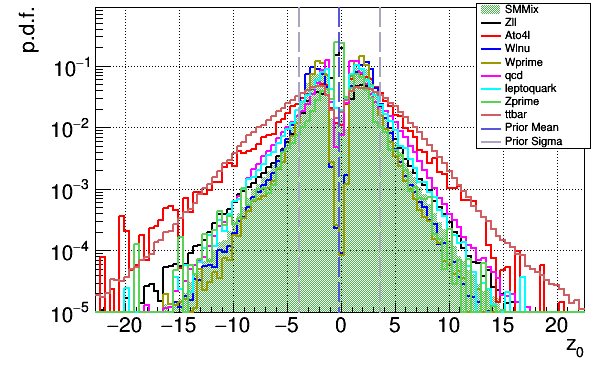

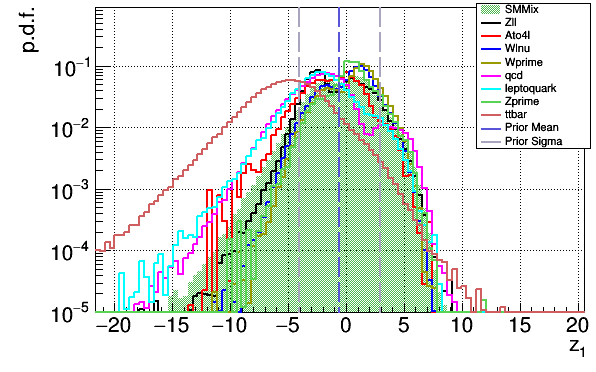

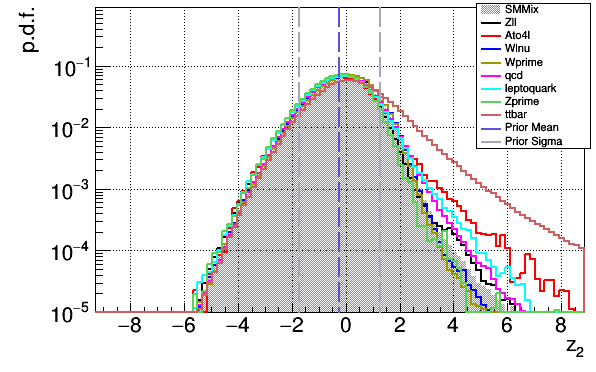

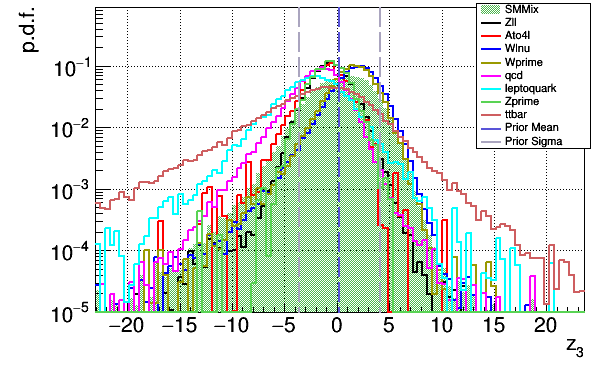

In [22]:
histos = []
canvases = []
N_bins = 100
rt.gStyle.SetOptTitle(0)

for kk in range(latent_dim):
    print 'Plotting dim', kk, '...'
    canvas = rt.TCanvas('c'+str(kk), 'c'+str(kk), 600, 400)
    canvas.SetLeftMargin(0.16)
    canvas.SetBottomMargin(0.16)
    canvas.SetRightMargin(0.02)
    canvas.SetTopMargin(0.02)

    l_bound = mu_prior[kk] - 6*sigma_prior[kk]
    u_bound = mu_prior[kk] + 6*sigma_prior[kk]
    bin_width = (u_bound - l_bound)/N_bins
    z = np.arange(l_bound, u_bound, bin_width)
    
    bin_content = sum_of_gaussians(z, x_train_encoded[0, :, kk], x_train_encoded[1, :, kk])*bin_width
    print '\t SMMix coverage: {:.3f}'.format(np.sum(bin_content))
    h = rt.TH1F('h_SMMix_{}'.format(kk), 'SMMix', N_bins, l_bound-bin_width/2., u_bound+bin_width/2.)
    for i,c in enumerate(bin_content): 
        h.SetBinContent(i+1, c)
    h.GetYaxis().SetRangeUser(1e-5, 0.9)
    h.SetStats(0)
    h.SetLineWidth(0)
    h.SetFillColorAlpha(rt.kGreen+2, 0.7)
    h.SetFillStyle(3001)
    
    h.SetXTitle('z_{'+str(kk)+'}')
    h.GetXaxis().SetTitleSize(0.06)
    h.GetXaxis().SetLabelSize(0.06)
    h.SetYTitle('p.d.f.')
    h.GetYaxis().SetTitleSize(0.06)
    h.GetYaxis().SetTitleOffset(1.16)
    h.GetYaxis().SetLabelSize(0.06)    
    
    h.Draw('Bar')
    histos.append(h)


    colors = [1,2,4,rt.kYellow+2,6,7,8,46, 30, 40]
    # fill
    for i, n in enumerate(x_sig.keys()):
        bin_content = sum_of_gaussians(z, x_sig_encoded[n][0, :, kk], x_sig_encoded[n][1, :, kk])*bin_width
        print '\t {} coverage: {:.3f}'.format(n, np.sum(bin_content))
        h = rt.TH1F('h_{}_{}'.format(n, kk), n, N_bins, l_bound-bin_width/2., u_bound+bin_width/2.)
        for j,c in enumerate(bin_content): 
            h.SetBinContent(j+1, c)

        h.SetStats(0)
        h.SetLineColor(colors[i])
        h.SetLineWidth(2)
        h.Draw('SAME')
        histos.append(h)
    leg = canvas.BuildLegend(0.8, 0.6, 0.99, 0.99, '','lf')
        
    line = rt.TLine()
    line.SetLineWidth(2)
    line.SetLineStyle(9)
    line.SetLineColor(9)
    l = line.DrawLine(mu_prior[kk], 1e-5, mu_prior[kk], 0.9)
    leg.AddEntry(l, 'Prior Mean', 'l')
    line.SetLineColor(40)
    l = line.DrawLine(mu_prior[kk]-sigma_prior[kk], 1e-5, mu_prior[kk]-sigma_prior[kk], 0.9)
    leg.AddEntry(l, 'Prior Sigma', 'l')
    
    line.DrawLine(mu_prior[kk]+sigma_prior[kk], 1e-5, mu_prior[kk]+sigma_prior[kk], 0.9)
    
    canvas.SetGrid()
    canvas.SetLogy()
    canvas.Draw()
    canvas.Update()
    canvases.append(canvas)
    
fout = rt.TFile('plots/all-in-one_v51_Zpdf.root', 'RECREATE')
for obj in canvases + histos:
    obj.Write()

fout.Close()

## Recostruction sum of pdf

In [23]:
pars_ae_train = autoencoder.predict(x_train, batch_size=2000)

pars_ae_sig = {}
for k,v in x_sig.iteritems():
    print k
    pars_ae_sig[k] = autoencoder.predict(v, batch_size=2000)

Zll
Ato4l
Wlnu
Wprime
qcd
leptoquark
Zprime
ttbar


HT
allJetMass
allMuPt
allMuMass
allElePt
allEleMass
LepPt
LepIsoCh
LepIsoGamma
LepIsoNeu
METp
METo
MT
nMu
nJets
bJets
nEle
LepCharge
LepIsEle
nChHad
nNeuHad


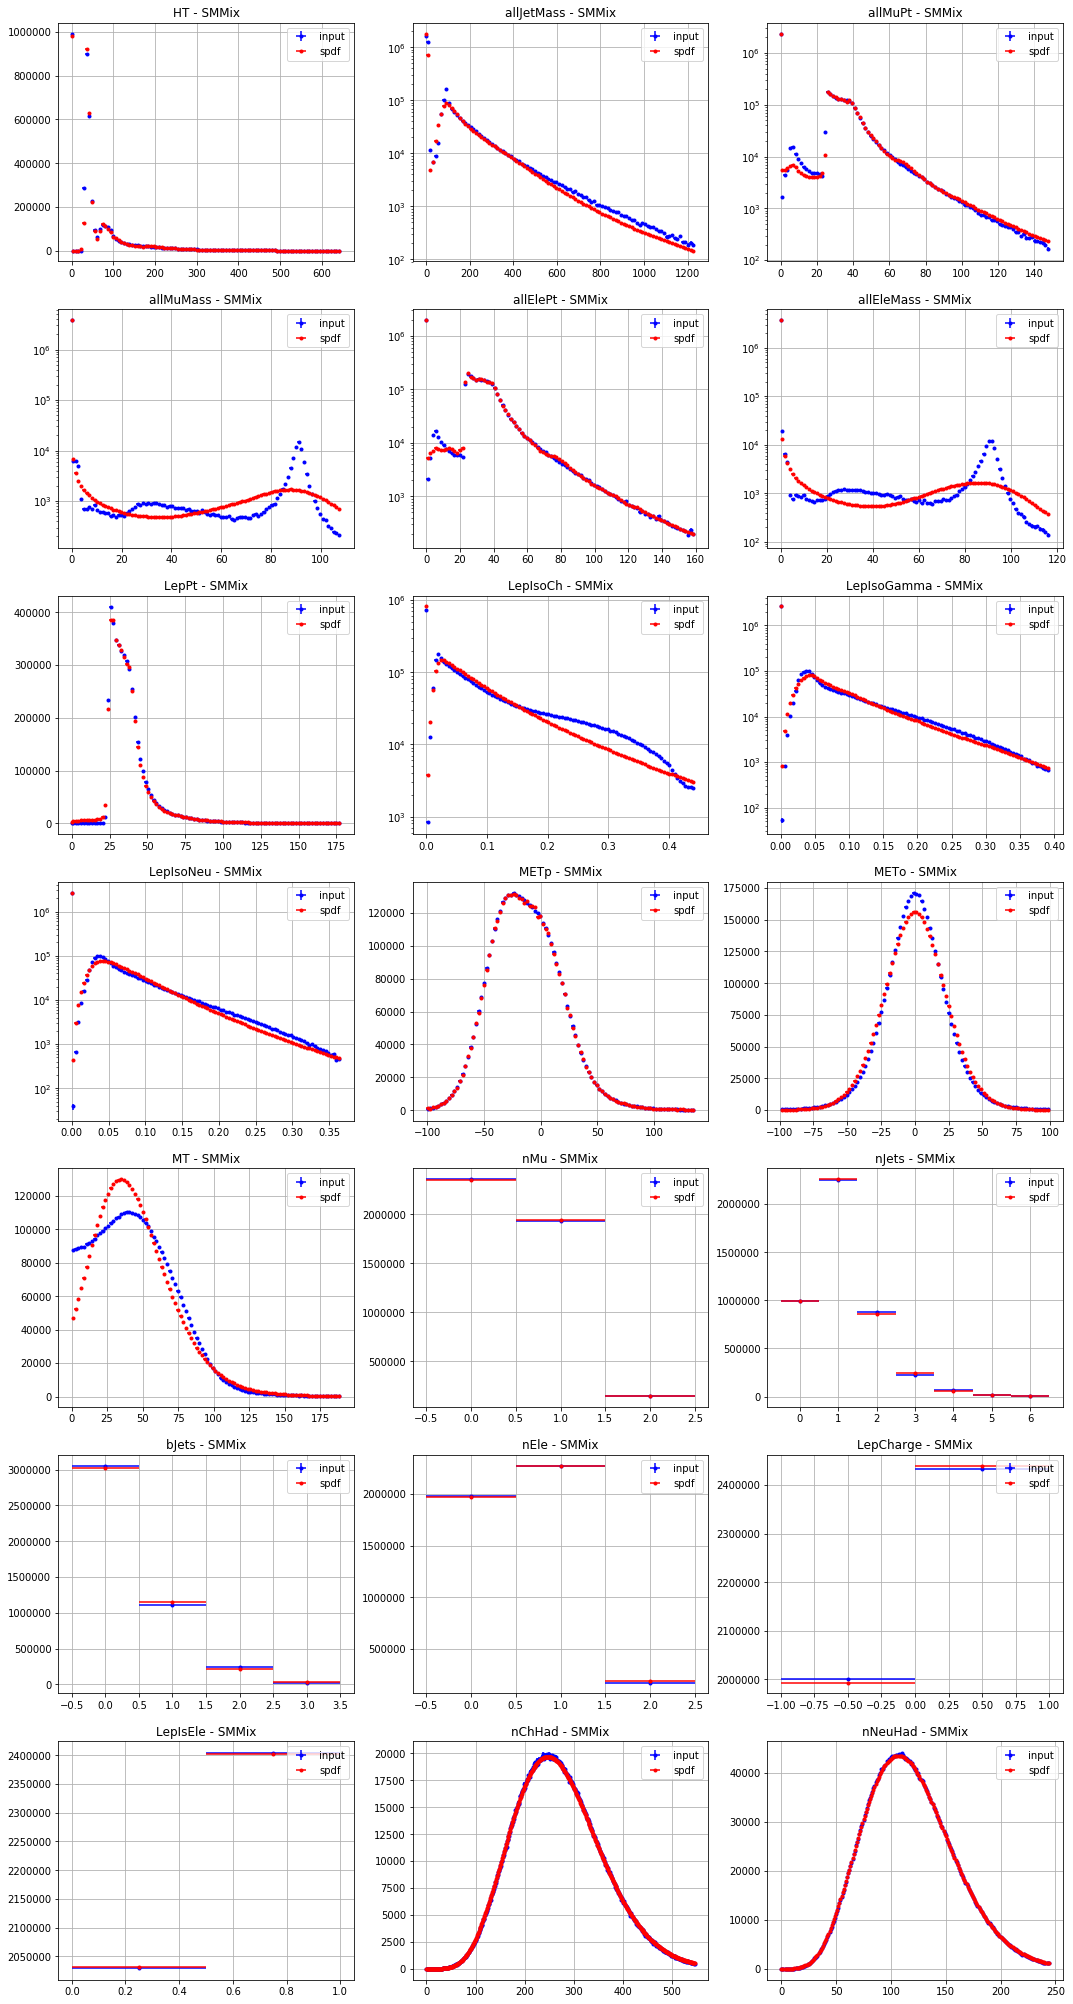

In [24]:
f, ax_arr = plt.subplots(int(len(active_hlf_features)/3.),3 , figsize=(18,36))
N_bins = 100
for i,hlf_name in enumerate(active_hlf_features):
    print hlf_name
    
    #Plot distribution of the variable
    x_aux = x_train[:, i]
    if i < Nf_lognorm:
        histo_range = (0, np.percentile(x_aux, 99.9))
        bin_content, bin_edges = np.histogram(x_aux, bins=N_bins, range=histo_range)
        if np.sum(bin_edges>clip_x_to0) > 0:
            i_aux = np.argmin(bin_edges<clip_x_to0)
            bin_edges = np.concatenate((np.array([0, clip_x_to0]), bin_edges[i_aux:]))
        else:
            bin_edges = np.array([0, clip_x_to0])
        bin_content, bin_edges = np.histogram(x_aux, bins=bin_edges, range=histo_range)
        bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
        bin_width = bin_edges[1:] - bin_edges[:-1]
        bin_width[0] = 1.

        mu_vec = pars_ae_train[0][:, i]
        sigma_vec = pars_ae_train[1][:, i]
        f_vec = pars_ae_train[2][:, i]
        spdf_bin_content = np.sum(bin_content)*bin_width*sum_of_lognorm(bincenters, f_vec, mu_vec, sigma_vec)
    elif i < Nf_lognorm + Nf_gauss:
        histo_range = (np.percentile(x_aux, .1), np.percentile(x_aux, 99.9))
        bin_content, bin_edges = np.histogram(x_aux, bins=N_bins, range=histo_range)
        bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
        bin_width = bincenters[1]-bincenters[0]

        mu_vec = pars_ae_train[0][:, i]
        sigma_vec = pars_ae_train[1][:, i]
        spdf_bin_content = np.sum(bin_content)*bin_width*sum_of_gaussians(bincenters, mu_vec, sigma_vec)
    elif i < Nf_lognorm + Nf_gauss + Nf_Pgauss:
        histo_range = (np.percentile(x_aux, .1), np.percentile(x_aux, 99.9))
        bin_content, bin_edges = np.histogram(x_aux, bins=N_bins, range=histo_range)
        bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
        bin_width = bincenters[1]-bincenters[0]

        mu_vec = pars_ae_train[0][:, i]
        sigma_vec = pars_ae_train[1][:, i]
        spdf_bin_content = np.sum(bin_content)*bin_width*sum_of_Pgauss(bincenters, mu_vec, sigma_vec)
    elif i < Nf_lognorm + Nf_gauss + Nf_Pgauss + Nf_PDgauss:
        Nmax = int(np.percentile(x_aux, 99.9))
        bin_content, bin_edges = np.histogram(x_aux, bins=Nmax+1, range=(-0.5, Nmax+0.5))
        bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
        bin_width = bincenters[1]-bincenters[0]

        mu_vec = pars_ae_train[0][:, i]
        sigma_vec = pars_ae_train[1][:, i]
        spdf_bin_content = np.sum(bin_content)*bin_width*sum_of_PDgauss(bincenters, mu_vec, sigma_vec)
    elif i < Nf_lognorm + Nf_gauss + Nf_Pgauss + Nf_PDgauss + Nf_binomial:
        bin_content, bin_edges = np.histogram(x_aux, bins=2, range=(np.min(x_aux), np.max(x_aux)))
        bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
        bin_width = bincenters[1]-bincenters[0]
        p = 0.5*(1+0.98*np.tanh(pars_ae_train[0][:, i]))

        spdf_bin_content = np.zeros_like(bincenters)
        spdf_bin_content[np.nonzero(bin_content)[0][1]] = np.sum(p)
        spdf_bin_content[np.nonzero(bin_content)[0][0]] = np.sum(1-p)
    else:
        Nmax = int(np.percentile(x_aux, 99.5))
        bin_content, bin_edges = np.histogram(x_aux, bins=Nmax+1, range=(-0.5, Nmax+0.5))
        bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
        bin_width = bincenters[1]-bincenters[0]
        aux = pars_ae_train[0][:, i]
        mu_vec = 1 + np.where(np.greater(aux, 0), aux, np.divide(aux, np.sqrt(1+np.square(aux))))
        spdf_bin_content = sum_of_possion(bincenters, mu_vec)


    if i < Nf_lognorm:
        bin_width[0] = clip_x_to0
        
    ax_arr[i/3, i%3].errorbar(bincenters, bin_content, xerr=bin_width/2., yerr=np.sqrt(bin_content), fmt='.b', label='input')
    ax_arr[i/3, i%3].errorbar(bincenters, spdf_bin_content, xerr=bin_width/2., fmt='.r', label='spdf')
    ax_arr[i/3, i%3].ticklabel_format(axis='y', style='sci')
    ax_arr[i/3, i%3].grid()
    ax_arr[i/3, i%3].set_title(hlf_name + ' - SMMix')        
    ax_arr[i/3, i%3].legend(loc='best')
    
    if hlf_name.startswith('LepIso') or hlf_name.startswith('all'):
        ax_arr[i/3, i%3].set_yscale('log')
        
        
f.savefig('plots/SMMix_SumOfPdfs_v51.pdf')        
plt.show()

# Test Statistics with Losses

In [25]:
print 'SMMix'
out = vae.predict(x_train, batch_size=2000)
loss_train = np.column_stack((weight_KL_loss*out[0]+out[1], out[1], out[0])).T

loss_sig = {}
for n in x_sig.keys():
    print n
    aux = vae.predict(x_sig[n], batch_size=2000)
    loss_sig[n] = np.column_stack((weight_KL_loss*aux[0]+aux[1], aux[1], aux[0])).T

SMMix
Zll
Ato4l
Wlnu
Wprime
qcd
leptoquark
Zprime
ttbar


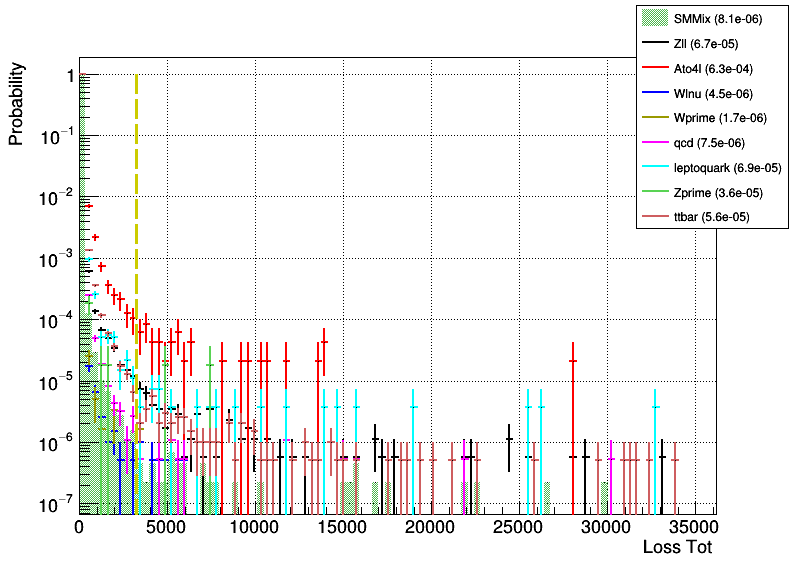

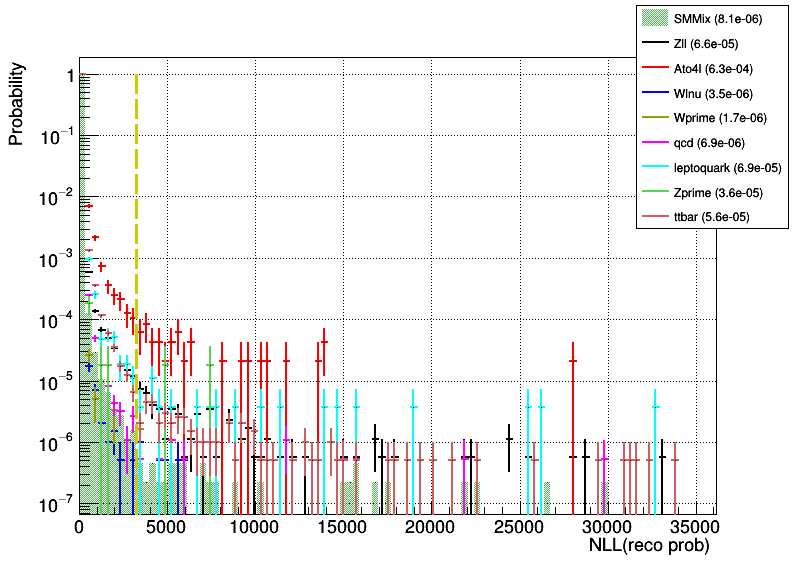

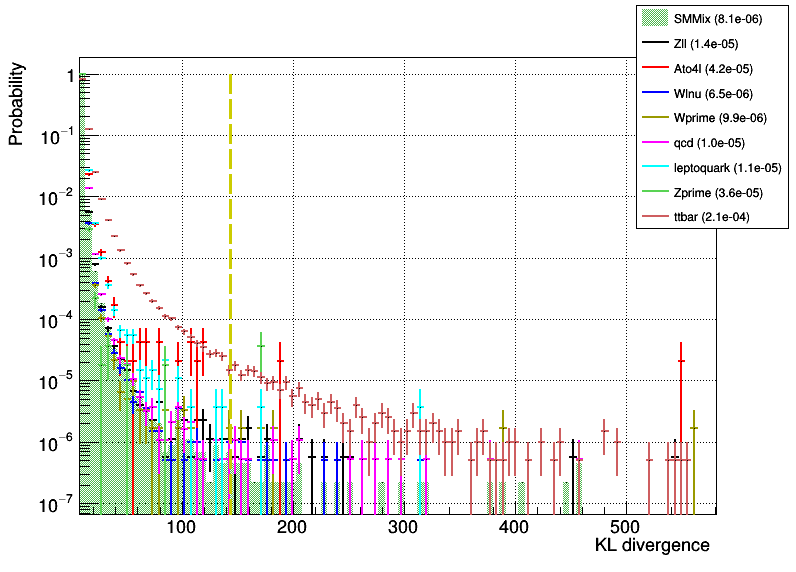

In [26]:
histos = []
canvases = []
Ytitles = ['Loss Tot', 'NLL(reco prob)', 'KL divergence']

eff_SMMix = 8.06e-6

for loss_piece in range(3):
    binning = [100, np.min(loss_train[loss_piece]), np.percentile(loss_train[loss_piece], 100*(1-1e-6))]
    c = rt.TCanvas('c'+str(loss_piece), 'c'+str(loss_piece), 800, 600)

    h = rt.TH1F('h_loss_SMMix_{}'.format(loss_piece), 'SMMix', binning[0], binning[1], binning[2])
    rtnp.fill_hist(h, loss_train[loss_piece])
    h.Scale(1./loss_train[loss_piece].shape[0])
    h.SetStats(0)
    h.SetLineWidth(0)
    h.SetFillColorAlpha(rt.kGreen+2, 0.7)
    h.SetFillStyle(3001)
    h.Draw('Bar SAME')
    histos.append(h)

    val_to_cut = np.percentile(loss_train[loss_piece], 100*(1-eff_SMMix))
    h.SetTitle(h.GetTitle()+' ({:1.1e})'.format(eff_SMMix))


    colors = [1,2,4,rt.kYellow+2,6,7,8,46, 30, 40]
    for i, n in enumerate(x_sig.keys()):
        z = loss_sig[n][loss_piece]
        eff = np.sum(z>val_to_cut)/float(z.shape[0])
        h1 = rt.TH1F('h_loss_{}_{}'.format(n, loss_piece), n+' ({:1.1e})'.format(eff), binning[0], binning[1], binning[2])
        rtnp.fill_hist(h1, z)
        h1.Scale(1./float(z.shape[0]))

        h1.SetStats(0)
        h1.SetLineColor(colors[i])
        h1.SetLineWidth(2)
        h1.Draw('SAME')
        histos.append(h1)

    c.BuildLegend(0.8, 0.6, 0.99, 0.99, '','lf')
    h.SetTitle('')
    h.SetXTitle(Ytitles[loss_piece])
    h.SetYTitle('Probability')

    line = rt.TLine()
    line.SetLineColor(rt.kYellow+1)
    line.SetLineWidth(3)
    line.SetLineStyle(9)
    line.DrawLine(val_to_cut,0, val_to_cut,1)

    c.SetGrid()
    c.SetLogy()
    c.Draw()
    canvases.append(c)
    
fout = rt.TFile('plots/all-in-one_v51_losses.root', 'RECREATE')
for obj in canvases + histos:
    obj.Write()

fout.Close()

In [27]:
SM_evts_per_month = 1000
SM_tot_xsec = 37.205e6 #fb

lumi_per_yr = 40 #fb^-1
DataColl_month = 8.

eff_SMMix = SM_evts_per_month/(SM_tot_xsec * lumi_per_yr/DataColl_month)
print 'Ideal Eff SM --->> {:.2e}\n\n\n'.format(eff_SMMix)

for ll in range(3):
    cut = np.percentile(loss_train[ll], 100*(1-eff_SMMix))
    
    print '----------------',Ytitles[ll], '----------------'
    table_SM = PrettyTable(['Sample', 'VAE Eff','Events fraction', 'evts/month'])
    table_BSM = PrettyTable(['Sample', 'VAE Eff', 'xsec (100 evts/month) [fb]', 'xsec (S/B = 0.3) [fb]'])
    
    N_tot = np.sum(loss_train[ll] > cut)
    effSM = float(N_tot)/loss_train[ll].shape[0]
    d_effSM = np.sqrt(effSM*(1-effSM)/loss_train[ll].shape[0])
    
    N_SM = effSM*SM_tot_xsec*lumi_per_yr/DataColl_month
    d_N_SM = N_SM*d_effSM/effSM
    
    SM_table_vals = []
    
    for n, lss in loss_sig.items():
        aux = np.greater(lss[ll,:], cut)
        selected = np.sum(aux)
        eff = float(selected)/lss.shape[1]
        d_eff = np.sqrt(eff*(1-eff)/lss.shape[1])
        
        if n in TrainSamplesName:
            idx = TrainSamplesName.index(n)
            N_evts = SM_tot_xsec*fraction[idx]*eff*lumi_per_yr/DataColl_month
            d_N_evts = N_evts*d_eff/eff
            table_SM.add_row([n,
                              '{:1.1e} +/- {:1.1e}'.format(eff, d_eff), 
                              '{:.2f} %'.format(100*float(N_evts/N_SM)),
                              '{:.0f} +/- {:.0f}'.format(N_evts, d_N_evts)])
        else:
            if eff == 0:
                print n, eff
                continue
            x_sec_lim = 100. * DataColl_month/(lumi_per_yr * eff)
            x_sec_SoB = 0.3* N_SM *DataColl_month/(lumi_per_yr * eff)
            table_BSM.add_row([n, 
                               '{:1.1e} +/- {:1.1e}'.format(eff, d_eff), 
                               '{:.1f}'.format(x_sec_lim), 
                               '{:1.1e}'.format(x_sec_SoB)])


    print table_SM
    print 'Eff VAE SM: {:.2e} +/- {:.2e}'.format(effSM, d_effSM)
    print 'Expected SM evts/month: {:.0f} +/- {:.0f}'.format(N_SM , d_N_SM)
    print table_BSM
    print '\n\n'

Ideal Eff SM --->> 5.38e-06



---------------- Loss Tot ----------------
Wprime 0.0
+--------+---------------------+-----------------+-------------+
| Sample |       VAE Eff       | Events fraction |  evts/month |
+--------+---------------------+-----------------+-------------+
|  Zll   | 3.9e-05 +/- 4.7e-06 |     48.75 %     |  491 +/- 59 |
|  Wlnu  | 1.5e-06 +/- 8.7e-07 |     16.40 %     |  165 +/- 95 |
|  qcd   | 4.8e-06 +/- 1.6e-06 |     30.00 %     | 302 +/- 101 |
| ttbar  | 3.6e-05 +/- 4.2e-06 |      2.00 %     |   20 +/- 2  |
+--------+---------------------+-----------------+-------------+
Eff VAE SM: 5.41e-06 +/- 1.10e-06
Expected SM evts/month: 1007 +/- 206
+------------+---------------------+----------------------------+-----------------------+
|   Sample   |       VAE Eff       | xsec (100 evts/month) [fb] | xsec (S/B = 0.3) [fb] |
+------------+---------------------+----------------------------+-----------------------+
|   Ato4l    | 2.9e-04 +/- 7.8e-05 |          68154.3 